In [1]:
from redbox.graph.root import get_redbox_graph, run_redbox
from redbox.graph.chat import get_chat_with_docs_graph
from redbox.chains import components
from redbox.models.settings import Settings, ElasticLocalSettings, AISettings
from redbox.models.chain import ChainInput, ChainState
from pathlib import Path
from dotenv import load_dotenv, dotenv_values
from langchain_openai import AzureChatOpenAI
import tiktoken

_ = load_dotenv(Path.cwd().parent / ".env")

ENV = Settings(
    minio_host="localhost", 
    object_store="minio", 
    azure_openai_model="gpt-4o",
    elastic=ElasticLocalSettings(host="localhost"),
)

llm = AzureChatOpenAI(
    api_key=ENV.azure_openai_api_key,
    azure_endpoint=ENV.azure_openai_endpoint,
    model=ENV.azure_openai_model,
)

AI_CONFIG = {"configurable": ENV.ai.dict()}

## State

In [2]:
from uuid import UUID
from langchain_core.documents import Document
from redbox.models.chat import ChatRoute
from typing import Annotated, TypedDict, Required, NotRequired
from functools import reduce


class DocumentState(TypedDict):
    group: dict[UUID, Document]


def document_reducer(left: DocumentState, right: DocumentState | list[DocumentState]) -> DocumentState:
    """Merges two document states based on the following rules.
    
    * Groups are matched by the group key.
    * Documents are matched by the group key and document key.

    Then:
    
    * If key(s) are matched, the group or Document is replaced
    * If key(s) are matched and the key is None, the key is cleared
    * If key(s) aren't matched, group or Document is added
    """
    # If right is actually a list of state updates, run them one by one
    if isinstance(right, list):
        reduced = reduce(lambda l, r: document_reducer(l, r), right, left)
        return reduced

    # If state is empty, return right
    if left is None:
        return right
    
    # Copy left
    reduced = {k: v.copy() for k, v in left.items()}
    
    # Update with right
    for group_key, group in right.items():
        # If group is None, remove from output if a group key is matched
        if group is None:
            reduced.pop(group_key, None)
            continue
        
        # If group key isn't matched, add it
        if group_key not in reduced:
            reduced[group_key] = group
        
        for document_key, document in group.items():
            if document is None:
                # If Document is None, remove from output if a group and document key is matched
                reduced[group_key].pop(document_key, None)
            else:
                # Otherwise, update or add the value
                reduced[group_key][document_key] = document

        # Remove group_key from output if it becomes empty after updates
        if not reduced[group_key]:
            del reduced[group_key]

    return reduced

class State(TypedDict):
    request: Required[ChainInput]
    text: NotRequired[str]
    documents: Annotated[NotRequired[DocumentState], document_reducer]
    route: NotRequired[ChatRoute]

In [3]:
x = {
    UUID("00000000-0000-0000-0000-000000000001"): {
        UUID("10000000-0000-0000-0000-000000000000"): Document(page_content="a"),
        UUID("20000000-0000-0000-0000-000000000000"): Document(page_content="b")
    },
    UUID("00000000-0000-0000-0000-000000000002"): {
        UUID("30000000-0000-0000-0000-000000000000"): Document(page_content="c"),
        UUID("40000000-0000-0000-0000-000000000000"): Document(page_content="d")
    }
}

y = {
    UUID("00000000-0000-0000-0000-000000000001"): {
        UUID("10000000-0000-0000-0000-000000000000"): Document(page_content="z"),
        UUID("20000000-0000-0000-0000-000000000000"): None,
        UUID("30000000-0000-0000-0000-000000000000"): Document(page_content="c")
    },
    UUID("00000000-0000-0000-0000-000000000002"): None
}

z = {
    UUID("00000000-0000-0000-0000-000000000001"): {
        UUID("10000000-0000-0000-0000-000000000000"): Document(page_content="z"),
        UUID("30000000-0000-0000-0000-000000000000"): Document(page_content="c")
    }
}

a = document_reducer(x, y)

a == z

True

In [4]:
x = {
    UUID("00000000-0000-0000-0000-000000000001"): {
        UUID("10000000-0000-0000-0000-000000000000"): Document(page_content="a"),
        UUID("20000000-0000-0000-0000-000000000000"): Document(page_content="b")
    },
    UUID("00000000-0000-0000-0000-000000000002"): {
        UUID("30000000-0000-0000-0000-000000000000"): Document(page_content="c"),
        UUID("40000000-0000-0000-0000-000000000000"): Document(page_content="d")
    }
}

y1 = {
    UUID("00000000-0000-0000-0000-000000000001"): {
        UUID("10000000-0000-0000-0000-000000000000"): Document(page_content="z"),
    },
}

y2 = {
    UUID("00000000-0000-0000-0000-000000000001"): {
        UUID("20000000-0000-0000-0000-000000000000"): None,
    }
}

y3 = {
    UUID("00000000-0000-0000-0000-000000000001"): {
        UUID("30000000-0000-0000-0000-000000000000"): Document(page_content="c")
    },
}

y4 = {
    UUID("00000000-0000-0000-0000-000000000002"): None
}

z = {
    UUID("00000000-0000-0000-0000-000000000001"): {
        UUID("10000000-0000-0000-0000-000000000000"): Document(page_content="z"),
        UUID("30000000-0000-0000-0000-000000000000"): Document(page_content="c")
    }
}

a = document_reducer(x, [y1, y2, y3, y4])

a == z

True

In [5]:
def flatten_document_state(documents: dict[UUID, dict[UUID, Document]]) -> list[Document]:
    return [
        document
        for group in documents.values()
        for document in group.values()
    ]

## Edges

In [28]:
import tiktoken
import re
from typing import Callable

def calculate_token_budget(state: State, config: AISettings) -> int:
    tokeniser = tiktoken.get_encoding("cl100k_base")

    len_question = len(tokeniser.encode(state["request"]["question"]))
    max_system_or_question_prompt = max(
        [
            len(tokeniser.encode(v))
            for k, v in config["configurable"].items() 
            if isinstance(v, str)
        ]
    )

    len_prompts = max_system_or_question_prompt * 2
    # config.llm_max_tokens is 1024 -- move max tokens to AISettings
    len_max_output = 1_024
    
    return config["configurable"]["context_window_size"] - len_max_output - len_prompts - len_question

def conditional_documents_bigger_than_context(state: State, config: AISettings) -> bool:
    token_budget = calculate_token_budget(state=state, config=config)
    documents = flatten_document_state(documents=state["documents"])

    if sum(d.metadata["token_count"] for d in documents) > token_budget:
        return True
    else:
        return False

def conditional_keyword_detection(state: State, config: AISettings) -> ChatRoute | None:
    re_keyword_pattern = re.compile(r"@(\w+)")

    route_match = re_keyword_pattern.search(state["request"]["question"])
    route_name = route_match.group()[1:] if route_match else None
    
    try:
        return ChatRoute[route_name]
    except KeyError:
        return "DEFAULT"

def conditional_documents_selected(state: State, config: AISettings) -> bool:
    return len(state["request"]["file_uuids"]) > 0

def conditional_multiple_docs_in_group(state: State, config: AISettings) -> bool:
    for group in state["documents"]:
        if len(state["documents"][group]) > 0:
            return True
    return False

def build_conditional(
    *predicates: Callable[[State, AISettings], bool], 
    outcome_map: dict[tuple[bool], Callable | str]
):
    """Allows the composition of predicates into either nodes or sends.
    
    Permits the use of None so some outcomes can ignore some predicates.    
    """
    def _conditional(state: State, config: AISettings) -> Callable | str:
        outcomes = tuple(predicate(state, config) for predicate in predicates)
        result_callable = outcome_map.get(outcomes)

        if result_callable is None:
            for key, func in outcome_map.items():
                if all(k is None or k == o for k, o in zip(key, outcomes)):
                    result_callable = func
                    break
        
        if result_callable is not None:
            return result_callable
        else:
            raise ValueError(f"No callable mapped for outcomes {outcomes}")
    
    return _conditional

## Sends

In [9]:
from langgraph.constants import Send
from typing import Callable

class SendFunction:
    def __init__(self, func, str):
        self.func = func
        self.str = str

    def __call__(self, *args, **kwargs):
        return self.func(*args, **kwargs)

    def __str__(self):
        return self.str

def build_document_group_send(target: str) -> Callable[[State, AISettings], list[Send]]:
    def _group_send(state: State, config: AISettings) -> list[Send]:
        group_send_states: list[State] = [
            State(
                request=state["request"],
                text=state.get("text"),
                documents={group_key: state["documents"][group_key]},
                route=state.get("route")
            )
            for group_key in state["documents"]
        ]
        return [Send(node=target, arg=state) for state in group_send_states]
    return _group_send

def build_document_chunk_send(target: str) -> Callable[[State, AISettings], list[Send]]:
    def _chunk_send(state: State, config: AISettings) -> list[Send]:
        chunk_send_states: list[State] = [
            State(
                request=state["request"],
                text=state.get("text"),
                documents={group_key: {document_key: state["documents"][group_key][document_key]}},
                route=state.get("route")
            )
            for group_key in state["documents"]
            for document_key in state["documents"][group_key]
        ]
        return [Send(node=target, arg=state) for state in chunk_send_states]
    return _chunk_send


## Patterns

In [8]:
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.output_parsers.string import StrOutputParser
from langchain_core.retrievers import BaseRetriever

from redbox.api.runnables import make_chat_prompt_from_messages_runnable

from typing import Any

def build_chat_pattern(
    system_prompt: str,
    question_prompt: str,
    llm: BaseChatModel,
) -> Callable[[State, AISettings], dict[str, Any]]:
    """Returns a function that uses state["request"] to set state["text"]."""
    def _chat(state: State, config: AISettings) -> dict[str, Any]:
        chat_chain = (
            make_chat_prompt_from_messages_runnable(
                system_prompt=system_prompt,
                question_prompt=question_prompt,
                input_token_budget=config["configurable"]["context_window_size"] - 1_024,
                tokeniser=tiktoken.get_encoding("cl100k_base"),
            )
            | llm
            | StrOutputParser()
        )
        
        return {
            "text": chat_chain.invoke(state["request"]),
        }

    return _chat

chat_state = State(
    request=ChainInput(
        question="Who are you?",
        file_uuids=[],
        user_uuid="a16b2762-fc18-4595-bafa-3d70f1e85087",
        chat_history=[],
    ).dict(),
    text=None,
    documents=None,
    route=None
)

chat_node = build_chat_pattern(
    system_prompt="You're a pirate.", 
    question_prompt="{question}\n\n Response: ",
    llm=llm
)

chat_node(chat_state, AI_CONFIG)

{'text': "Arrr, matey! I be Captain Redbeard, the scourge of the seven seas and master of the Jolly Roger! What be ye wantin' with this old sea dog, eh? Speak up, or I'll have ye swabbin' the deck 'til the sun sets!"}

In [10]:
def build_passthrough_pattern() -> Callable[[State, AISettings], dict[str, Any]]:
    """Returns a function that uses state["request"] to set state["text"]."""
    def _passthrough(state: State, config: AISettings) -> dict[str, Any]:
        return {
            "text": state["request"]["question"],
        }
    
    return _passthrough
    
passthrough_state = State(
    request=ChainInput(
        question="Who are you?",
        file_uuids=[],
        user_uuid="a16b2762-fc18-4595-bafa-3d70f1e85087",
        chat_history=[],
    ).dict(),
    text=None,
    documents=None,
    route=None
)

passthrough_node = build_passthrough_pattern()

passthrough_node(passthrough_state, AI_CONFIG)

{'text': 'Who are you?'}

In [11]:
def build_canned_pattern(canned: str) -> Callable[[State, AISettings], dict[str, Any]]:
    """Returns a function that uses state["request"] to set state["text"]."""
    def _canned(state: State, config: AISettings) -> dict[str, Any]:
        return {
            "text": canned,
        }
    
    return _canned
    
canned_state = State(
    request=ChainInput(
        question="Who are you?",
        file_uuids=[],
        user_uuid="a16b2762-fc18-4595-bafa-3d70f1e85087",
        chat_history=[],
    ).dict(),
    text=None,
    documents=None,
    route=None
)

canned_node = build_canned_pattern(canned="I am the walrus")

canned_node(canned_state, AI_CONFIG)

{'text': 'I am the walrus'}

In [12]:
from langchain_core.runnables import RunnablePassthrough 

from redbox.api.format import format_documents

from operator import itemgetter

def build_stuff_pattern(
    system_prompt: str,
    question_prompt: str,
    llm: BaseChatModel,
) -> Callable[[State, AISettings], dict[str, Any]]:
    """Returns a function that uses state["request"] and state["documents"] to set state["text"]."""
    def _stuff(state: State, config: AISettings) -> dict[str, Any]:
        stuff_chain = (
            RunnablePassthrough.assign(
                documents=(
                    RunnablePassthrough() 
                    | itemgetter("documents") 
                    | flatten_document_state 
                    | format_documents
                )
            ) 
            | make_chat_prompt_from_messages_runnable(
                system_prompt=system_prompt,
                question_prompt=question_prompt,
                input_token_budget=config["configurable"]["context_window_size"] - 1_024,
                tokeniser=tiktoken.get_encoding("cl100k_base"),
            )
            | llm
            | StrOutputParser()
        )
        
        return {
            "text": stuff_chain.invoke({
                **state["request"],
                "documents": state["documents"]
            })
        }

    return _stuff

stuff_state = State(
    request=ChainInput(
        question="What animals are named in these documents?",
        file_uuids=["71b76e2a-9c2f-4340-ba94-cc09c7de74ff"],
        user_uuid="a16b2762-fc18-4595-bafa-3d70f1e85087",
        chat_history=[],
    ).dict(),
    text=None,
    documents={
        UUID("00000000-0000-0000-0000-000000000001"): {
            UUID("10000000-0000-0000-0000-000000000000"): Document(
                page_content="A dog is a type of mammal.",
                metadata={
                    "uuid": UUID("10000000-0000-0000-0000-000000000000"),
                    "parent_file_uuid": UUID("00000000-0000-0000-0000-000000000001"),
                    "token_count": 6,
                }
            ),
            UUID("20000000-0000-0000-0000-000000000000"): Document(
                page_content="A cat is a type of mammal.",
                metadata={
                    "uuid": UUID("20000000-0000-0000-0000-000000000000"),
                    "parent_file_uuid": UUID("00000000-0000-0000-0000-000000000001"),
                    "token_count": 6,
                }
            )
        },
        UUID("00000000-0000-0000-0000-000000000002"): {
            UUID("30000000-0000-0000-0000-000000000000"): Document(
                page_content="A swift is a type of bird.",
                metadata={
                    "uuid": UUID("30000000-0000-0000-0000-000000000000"),
                    "parent_file_uuid": UUID("00000000-0000-0000-0000-000000000002"),
                    "token_count": 6,
                }
            ),
            UUID("40000000-0000-0000-0000-000000000000"): Document(
                page_content="A shrike is a type of bird.",
                metadata={
                    "uuid": UUID("40000000-0000-0000-0000-000000000000"),
                    "parent_file_uuid": UUID("00000000-0000-0000-0000-000000000002"),
                    "token_count": 6,
                }
            )
        }
    },
    route=None
)

stuff_node = build_stuff_pattern(
    system_prompt="Summarise these documents.", 
    question_prompt="Question: {question}. \n\n Documents: \n\n {documents} \n\n Answer:",
    llm=llm
)

stuff_node(stuff_state, AI_CONFIG)

{'text': 'The animals named in the documents are:\n\n1. Dog\n2. Cat\n3. Swift\n4. Shrike'}

In [13]:
from redbox.transform import combine_documents

from functools import reduce
from uuid import uuid4

def build_merge_pattern(
    system_prompt: str,
    question_prompt: str,
    llm: BaseChatModel,
) -> Callable[[State, AISettings], dict[str, Any]]:
    """Returns a function that uses state["request"] and state["documents"] to return one item in state["documents"].
    
    When combined with chunk send, will replace each Document with what's returned from the LLM.

    When combined with group end, with combine all Documents and use the metadata of the first.

    When used without a send, the first Document receieved defines the metadata.
    """
    def _merge(state: State, config: AISettings) -> dict[str, Any]:
        tokeniser = tiktoken.get_encoding("cl100k_base")

        flattened_documents = flatten_document_state(state["documents"])
        
        merged_document = reduce(lambda l, r: combine_documents(l, r), flattened_documents)
        
        stuff_chain = (
            RunnablePassthrough.assign(
                documents=(
                    RunnablePassthrough() 
                    | itemgetter("documents") 
                    | flatten_document_state 
                    | format_documents
                )
            ) 
            | make_chat_prompt_from_messages_runnable(
                system_prompt=system_prompt,
                question_prompt=question_prompt,
                input_token_budget=config["configurable"]["context_window_size"] - 1_024,
                tokeniser=tokeniser,
            )
            | llm
            | StrOutputParser()
        )
        
        merged_document.page_content = stuff_chain.invoke({
            **state["request"],
            "documents": state["documents"]
        })
        merged_document.metadata["token_count"] = len(
            tokeniser.encode(merged_document.page_content)
        )

        group_uuid = merged_document.metadata.get("parent_file_uuid", uuid4())
        document_uuid = merged_document.metadata.get("uuid", uuid4())

        # Clear old documents, add new one
        document_state = state["documents"].copy()
        
        for group in document_state:
            for document in document_state[group]:
                document_state[group][document] = None
        
        document_state[group_uuid][document_uuid] = merged_document
        
        return {
            "documents": document_state
        }

    return _merge

merge_state = State(
    request=ChainInput(
        question="What animals are named in these documents?",
        file_uuids=["71b76e2a-9c2f-4340-ba94-cc09c7de74ff"],
        user_uuid="a16b2762-fc18-4595-bafa-3d70f1e85087",
        chat_history=[],
    ).dict(),
    text=None,
    documents={
        UUID("00000000-0000-0000-0000-000000000001"): {
            UUID("10000000-0000-0000-0000-000000000000"): Document(
                page_content="A dog is a type of mammal.",
                metadata={
                    "uuid": UUID("10000000-0000-0000-0000-000000000000"),
                    "parent_file_uuid": UUID("00000000-0000-0000-0000-000000000001"),
                    "token_count": 6,
                }
            ),
            UUID("20000000-0000-0000-0000-000000000000"): Document(
                page_content="A cat is a type of mammal.",
                metadata={
                    "uuid": UUID("20000000-0000-0000-0000-000000000000"),
                    "parent_file_uuid": UUID("00000000-0000-0000-0000-000000000001"),
                    "token_count": 6,
                }
            )
        },
        UUID("00000000-0000-0000-0000-000000000002"): {
            UUID("30000000-0000-0000-0000-000000000000"): Document(
                page_content="A swift is a type of bird.",
                metadata={
                    "uuid": UUID("30000000-0000-0000-0000-000000000000"),
                    "parent_file_uuid": UUID("00000000-0000-0000-0000-000000000002"),
                    "token_count": 6,
                }
            ),
            UUID("40000000-0000-0000-0000-000000000000"): Document(
                page_content="A shrike is a type of bird.",
                metadata={
                    "uuid": UUID("40000000-0000-0000-0000-000000000000"),
                    "parent_file_uuid": UUID("00000000-0000-0000-0000-000000000002"),
                    "token_count": 6,
                }
            )
        }
    },
    route=None
)

merge_node = build_merge_pattern(
    system_prompt="Summarise these documents.", 
    question_prompt="Question: {question}. \n\n Documents: \n\n {documents} \n\n Answer:",
    llm=llm
)

merge_node(merge_state, AI_CONFIG)


{'documents': {UUID('00000000-0000-0000-0000-000000000001'): {UUID('10000000-0000-0000-0000-000000000000'): Document(metadata={'uuid': UUID('10000000-0000-0000-0000-000000000000'), 'parent_file_uuid': UUID('00000000-0000-0000-0000-000000000001'), 'token_count': 24, 'page_number': None, 'languages': None, 'link_texts': None, 'link_urls': None, 'links': None}, page_content='The animals named in these documents are:\n\n1. Dog\n2. Cat\n3. Swift\n4. Shrike'),
   UUID('20000000-0000-0000-0000-000000000000'): None},
  UUID('00000000-0000-0000-0000-000000000002'): {UUID('30000000-0000-0000-0000-000000000000'): None,
   UUID('40000000-0000-0000-0000-000000000000'): None}}}

In [14]:
def build_retrieve_pattern(
    retriever: BaseRetriever
) -> Callable[[State, AISettings], dict[str, Any]]:
    """Returns a function that uses state["request"] and state["text"] to set state["documents"]."""
    def _retrieve(state: State, config: AISettings) -> dict[str, Any]:
        document_states: list[DocumentState] = []
        request = state["request"]
        request["question"] = state["text"]

        for document in retriever.invoke(request):
            group_uuid = document.metadata.get("parent_file_uuid", uuid4())
            chunk_uuid = document.metadata.get("uuid", uuid4())
            document_states.append({ group_uuid: { chunk_uuid: document } })
    
        return {
            "documents": reduce(lambda l, r: document_reducer(l, r), document_states)
        }

    return _retrieve


class FakeRetriever(BaseRetriever):
    docs: list[Document]

    def _get_relevant_documents(self, query: str) -> list[Document]:
        return self.docs

    async def _aget_relevant_documents(self, query: str) -> list[Document]:
        return self.docs


fake_retriever = FakeRetriever(
    docs=[
        Document(
            page_content="A dog is a type of mammal.",
            metadata={
                "uuid": UUID("10000000-0000-0000-0000-000000000000"),
                "parent_file_uuid": UUID("00000000-0000-0000-0000-000000000001"),
                "token_count": 6,
            }
        ),
        Document(
            page_content="A cat is a type of mammal.",
            metadata={
                "uuid": UUID("20000000-0000-0000-0000-000000000000"),
                "parent_file_uuid": UUID("00000000-0000-0000-0000-000000000001"),
                "token_count": 6,
            }
        ),
        Document(
            page_content="A swift is a type of bird.",
            metadata={
                "uuid": UUID("30000000-0000-0000-0000-000000000000"),
                "parent_file_uuid": UUID("00000000-0000-0000-0000-000000000002"),
                "token_count": 6,
            }
        ),
        Document(
            page_content="A shrike is a type of bird.",
            metadata={
                "uuid": UUID("40000000-0000-0000-0000-000000000000"),
                "parent_file_uuid": UUID("00000000-0000-0000-0000-000000000002"),
                "token_count": 6,
            }
        )
    ]
)

retrieve_state = State(
    request=ChainInput(
        question="What are some animals?",
        file_uuids=["71b76e2a-9c2f-4340-ba94-cc09c7de74ff"],
        user_uuid="a16b2762-fc18-4595-bafa-3d70f1e85087",
        chat_history=[],
    ).dict(),
    text=None,
    documents=None,
    route=None
)

retrieve_node = build_retrieve_pattern(retriever=fake_retriever)

document_state = retrieve_node(retrieve_state, AI_CONFIG)

for group in document_state["documents"]:
    print(f"Group:{group}")
    for document in document_state["documents"][group]:
        print(f"Document:{document}")
    print("---")

Group:00000000-0000-0000-0000-000000000001
Document:10000000-0000-0000-0000-000000000000
Document:20000000-0000-0000-0000-000000000000
---
Group:00000000-0000-0000-0000-000000000002
Document:30000000-0000-0000-0000-000000000000
Document:40000000-0000-0000-0000-000000000000
---


## Subgraphs

In [55]:
from langgraph.graph import StateGraph, START, END

chat = StateGraph(State)

# Nodes
chat.add_node(
    "p_chat",
    build_chat_pattern(
        system_prompt="You're a pirate.", 
        question_prompt="{question}\n\n Response: ",
        llm=llm
    )
)

# Edges
chat.add_edge(START, "p_chat")
chat.add_edge("p_chat", END)

chat_compiled = chat.compile()

chat_state = State(
    request=ChainInput(
        question="What are some animals? Mention your name.",
        file_uuids=["71b76e2a-9c2f-4340-ba94-cc09c7de74ff"],
        user_uuid="a16b2762-fc18-4595-bafa-3d70f1e85087",
        chat_history=[
            {"role": "user", "text": "Who are ye?"},
            {"role": "ai", "text": "Avast ye I'm Blackbeard!"},
        ],
    ).dict(),
    text=None,
    documents=None,
    route=None
)

chat_compiled.invoke(input=chat_state, config=AI_CONFIG)


{'request': {'question': 'What are some animals? Mention your name.',
  'file_uuids': [UUID('71b76e2a-9c2f-4340-ba94-cc09c7de74ff')],
  'user_uuid': UUID('a16b2762-fc18-4595-bafa-3d70f1e85087'),
  'chat_history': [{'role': 'user', 'text': 'Who are ye?'},
   {'role': 'ai', 'text': "Avast ye I'm Blackbeard!"}]},
 'text': 'Arrr, some animals be parrots, dolphins, and monkeys, matey! And don’t ye forget, the name’s Blackbeard!',
 'documents': None,
 'route': None}

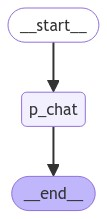

In [56]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        chat_compiled.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [52]:
from langgraph.graph import StateGraph, START, END

rag = StateGraph(State)

# Nodes
rag.add_node(
    "p_chat",
    build_chat_pattern(
        system_prompt="Write the following chat as a single question.", 
        question_prompt="{question}\n\n Single question: ",
        llm=llm
    )
)
rag.add_node(
    "p_retrieve", 
    build_retrieve_pattern(retriever=fake_retriever)
)
rag.add_node(
    "p_stuff",
    build_stuff_pattern(
        system_prompt="Summarise these documents.", 
        question_prompt="Question: {question}. \n\n Documents: \n\n {documents} \n\n Answer:",
        llm=llm
    )
)

# Edges
rag.add_edge(START, "p_chat")
rag.add_edge("p_chat", "p_retrieve")
rag.add_edge("p_retrieve", "p_stuff")
rag.add_edge("p_stuff", END)

rag_compiled = rag.compile()

rag_state = State(
    request=ChainInput(
        question="Can you name some?",
        file_uuids=["71b76e2a-9c2f-4340-ba94-cc09c7de74ff"],
        user_uuid="a16b2762-fc18-4595-bafa-3d70f1e85087",
        chat_history=[
            {"role": "user", "text": "Pick between insects and animals."},
            {"role": "ai", "text": "I pick animals."},
        ],
    ).dict(),
    text=None,
    documents=None,
    route=None
)

rag_compiled.invoke(input=rag_state, config=AI_CONFIG)


{'request': {'question': 'Can you name some animals?',
  'file_uuids': [UUID('71b76e2a-9c2f-4340-ba94-cc09c7de74ff')],
  'user_uuid': UUID('a16b2762-fc18-4595-bafa-3d70f1e85087'),
  'chat_history': [{'role': 'user',
    'text': 'Pick between insects and animals.'},
   {'role': 'ai', 'text': 'I pick animals.'}]},
 'text': 'Some animals include dogs and cats, which are types of mammals, as well as swifts and shrikes, which are types of birds.',
 'documents': {UUID('00000000-0000-0000-0000-000000000001'): {UUID('10000000-0000-0000-0000-000000000000'): Document(metadata={'uuid': UUID('10000000-0000-0000-0000-000000000000'), 'parent_file_uuid': UUID('00000000-0000-0000-0000-000000000001'), 'token_count': 13}, page_content='Some animals include dogs, which are a type of mammal.'),
   UUID('20000000-0000-0000-0000-000000000000'): Document(metadata={'uuid': UUID('20000000-0000-0000-0000-000000000000'), 'parent_file_uuid': UUID('00000000-0000-0000-0000-000000000001'), 'token_count': 13}, page_c

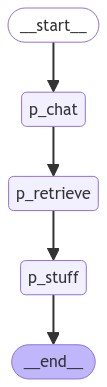

In [57]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        rag_compiled.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [18]:
fake_long_retriever = FakeRetriever(
    docs=[
        Document(
            page_content="A dog is a type of mammal. " * 1000,
            metadata={
                "uuid": UUID("10000000-0000-0000-0000-000000000000"),
                "parent_file_uuid": UUID("00000000-0000-0000-0000-000000000001"),
                "token_count": 6,
            }
        ),
        Document(
            page_content="A cat is a type of mammal. "  * 1000,
            metadata={
                "uuid": UUID("20000000-0000-0000-0000-000000000000"),
                "parent_file_uuid": UUID("00000000-0000-0000-0000-000000000001"),
                "token_count": 6,
            }
        ),
        Document(
            page_content="A swift is a type of bird. " * 1000,
            metadata={
                "uuid": UUID("30000000-0000-0000-0000-000000000000"),
                "parent_file_uuid": UUID("00000000-0000-0000-0000-000000000002"),
                "token_count": 6,
            }
        ),
        Document(
            page_content="A shrike is a type of bird. " * 1000,
            metadata={
                "uuid": UUID("40000000-0000-0000-0000-000000000000"),
                "parent_file_uuid": UUID("00000000-0000-0000-0000-000000000002"),
                "token_count": 6,
            }
        )
    ]
)

In [44]:
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables import RunnablePassthrough

cwd = StateGraph(State)

# Processes
cwd.add_node(
    "p_passthrough",
    build_passthrough_pattern()
)
cwd.add_node(
    "p_retrieve", 
    build_retrieve_pattern(retriever=fake_retriever)
    # build_retrieve_pattern(retriever=fake_long_retriever)
)
cwd.add_node(
    "p_shrink",
    build_merge_pattern(
        system_prompt="Summarise these documents.", 
        question_prompt="Question: {question}. \n\n Documents: \n\n {documents} \n\n Answer:",
        llm=llm
    )
)
# cwd.add_node("cwd_mc_window", RunnablePassthrough())
cwd.add_node(
    "p_mc_merge",
    build_merge_pattern(
        system_prompt="Summarise these documents.", 
        question_prompt="Question: {question}. \n\n Documents: \n\n {documents} \n\n Answer:",
        llm=llm
    )
)
cwd.add_node(
    "p_stuff",
    build_stuff_pattern(
        system_prompt="Summarise these documents.", 
        question_prompt="Question: {question}. \n\n Documents: \n\n {documents} \n\n Answer:",
        llm=llm
    )
)
cwd.add_node(
    "p_canned_error",
    build_canned_pattern(canned="These documents are too large to work with.")
)

# Decisions
cwd.add_node("d_docs_bigger_than_context_1", RunnablePassthrough())
cwd.add_node("d_docs_bigger_than_context_2", RunnablePassthrough())
cwd.add_node("d_docs_bigger_than_context_3", RunnablePassthrough())
cwd.add_node("d_groups_have_multiple_docs", RunnablePassthrough())

# Sends
cwd.add_node("s_chunk_send_to_shrink", RunnablePassthrough())
cwd.add_node("s_group_send_to_docs_bigger_2", RunnablePassthrough())
cwd.add_node("s_group_send_to_mc_merge", RunnablePassthrough())

# Edges
cwd.add_edge(START, "p_passthrough")
cwd.add_edge("p_passthrough", "p_retrieve")
cwd.add_edge("p_retrieve", "d_docs_bigger_than_context_1")
cwd.add_conditional_edges(
    "d_docs_bigger_than_context_1",
    conditional_documents_bigger_than_context,
    {
        True: "s_chunk_send_to_shrink",
        False: "p_stuff",
    }
)
cwd.add_conditional_edges(
    "s_chunk_send_to_shrink",
    build_document_chunk_send("p_shrink"),
    path_map=["p_shrink"]
)
cwd.add_edge("p_shrink", "d_groups_have_multiple_docs")
cwd.add_conditional_edges(
    "d_groups_have_multiple_docs",
    conditional_multiple_docs_in_group,
    {
        True: "s_group_send_to_docs_bigger_2",
        False: "d_docs_bigger_than_context_3",
    }
)
cwd.add_conditional_edges(
    "s_group_send_to_docs_bigger_2",
    build_document_group_send("d_docs_bigger_than_context_2"),
    path_map=["d_docs_bigger_than_context_2"]
)
cwd.add_conditional_edges(
    "d_docs_bigger_than_context_2",
    conditional_documents_bigger_than_context,
    {
        True: "s_group_send_to_mc_merge",
        False: "p_canned_error",
    }
)
cwd.add_conditional_edges(
    "s_group_send_to_mc_merge",
    build_document_group_send("p_mc_merge"),
    path_map=["p_mc_merge"]
)
cwd.add_edge("p_mc_merge", "d_docs_bigger_than_context_3")
cwd.add_conditional_edges(
    "d_docs_bigger_than_context_3",
    conditional_documents_bigger_than_context,
    {
        True: "p_canned_error",
        False: "p_stuff",
    }
)
cwd.add_edge("p_canned_error", END)
cwd.add_edge("p_stuff", END)

# Compile and go
cwd_compiled = cwd.compile()

cwd_state = State(
    request=ChainInput(
        question="What are some animals?",
        file_uuids=["71b76e2a-9c2f-4340-ba94-cc09c7de74ff"],
        user_uuid="a16b2762-fc18-4595-bafa-3d70f1e85087",
        chat_history=[],
    ).dict(),
    text=None,
    documents=None,
    route=None
)

AI_SMALL_CONTEXT_CONFIG = AI_CONFIG.copy()
AI_SMALL_CONTEXT_CONFIG["configurable"]["context_window_size"] = 2000

# cwd_compiled.invoke(input=cwd_state, config=AI_CONFIG)
cwd_compiled.invoke(input=cwd_state, config=AI_SMALL_CONTEXT_CONFIG)

{'request': {'question': 'What are some animals?',
  'file_uuids': [UUID('71b76e2a-9c2f-4340-ba94-cc09c7de74ff')],
  'user_uuid': UUID('a16b2762-fc18-4595-bafa-3d70f1e85087'),
  'chat_history': []},
 'text': 'Some animals mentioned in the documents include:\n1. Dogs (a type of mammal)\n2. Cats (a type of mammal)\n3. Swifts (a type of bird)\n4. Shrikes (a type of bird)',
 'documents': {UUID('00000000-0000-0000-0000-000000000001'): {UUID('10000000-0000-0000-0000-000000000000'): Document(metadata={'uuid': UUID('10000000-0000-0000-0000-000000000000'), 'parent_file_uuid': UUID('00000000-0000-0000-0000-000000000001'), 'token_count': 13}, page_content='Some animals include dogs, which are a type of mammal.'),
   UUID('20000000-0000-0000-0000-000000000000'): Document(metadata={'uuid': UUID('20000000-0000-0000-0000-000000000000'), 'parent_file_uuid': UUID('00000000-0000-0000-0000-000000000001'), 'token_count': 13}, page_content='Some animals include cats, which are a type of mammal.')},
  UUID(

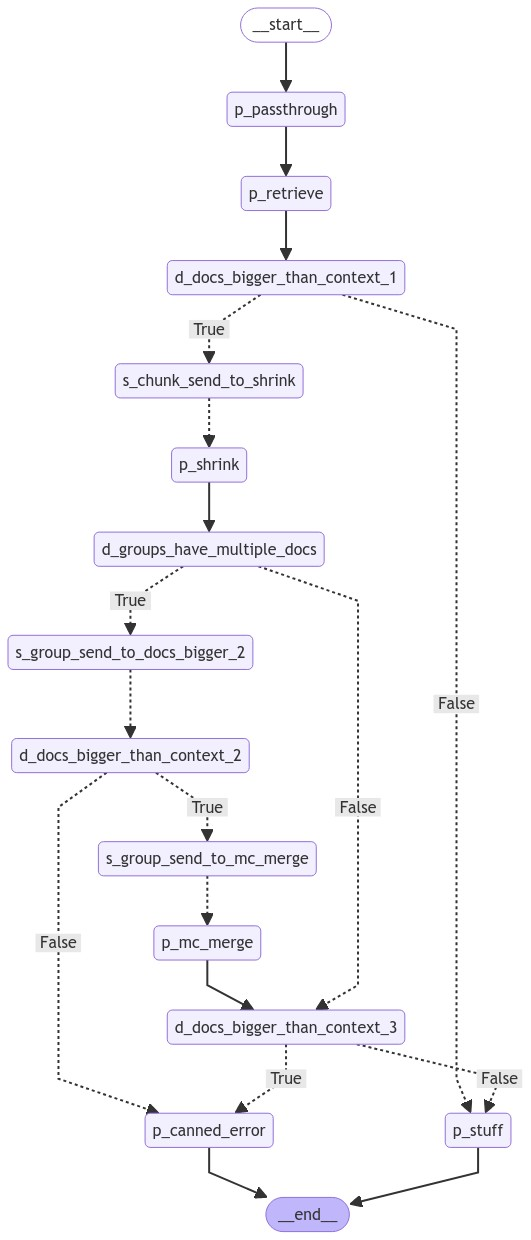

In [46]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        cwd_compiled.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Graph

In [53]:
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables import RunnablePassthrough

app = StateGraph(State)

# Nodes
app.add_node("p_search", rag_compiled)
app.add_node("p_chat", chat_compiled)
app.add_node("p_cwd", cwd_compiled)

# Decisions
app.add_node("d_keyword_exists", RunnablePassthrough())
app.add_node("d_docs_selected", RunnablePassthrough())

# Edges
app.add_edge(START, "d_keyword_exists")
app.add_conditional_edges(
    "d_keyword_exists", 
    conditional_keyword_detection,
    {
        "search": "p_search",
        "chat": "p_chat",
        "summarise": "p_cwd",
        "DEFAULT": "d_docs_selected"
    }
)
app.add_conditional_edges(
    "d_docs_selected", 
    conditional_documents_selected,
    {
        True: "p_cwd",
        False: "p_chat",
    }
)

app.add_edge("p_search", END)
app.add_edge("p_chat", END)
app.add_edge("p_cwd", END)

# Compile and go
app_compiled = app.compile()

app_state = State(
    request=ChainInput(
        question="What are some animals?",
        file_uuids=["71b76e2a-9c2f-4340-ba94-cc09c7de74ff"],
        user_uuid="a16b2762-fc18-4595-bafa-3d70f1e85087",
        chat_history=[],
    ).dict(),
    text=None,
    documents=None,
    route=None
)

AI_SMALL_CONTEXT_CONFIG = AI_CONFIG.copy()
AI_SMALL_CONTEXT_CONFIG["configurable"]["context_window_size"] = 2000

# cwd_compiled.invoke(input=cwd_state, config=AI_CONFIG)
app_compiled.invoke(input=app_state, config=AI_SMALL_CONTEXT_CONFIG)

{'request': {'question': 'What are some animals?',
  'file_uuids': [UUID('71b76e2a-9c2f-4340-ba94-cc09c7de74ff')],
  'user_uuid': UUID('a16b2762-fc18-4595-bafa-3d70f1e85087'),
  'chat_history': []},
 'text': 'Some animals include dogs and cats, which are types of mammals, and swifts and shrikes, which are types of birds.',
 'documents': {UUID('00000000-0000-0000-0000-000000000001'): {UUID('10000000-0000-0000-0000-000000000000'): Document(metadata={'uuid': UUID('10000000-0000-0000-0000-000000000000'), 'parent_file_uuid': UUID('00000000-0000-0000-0000-000000000001'), 'token_count': 13}, page_content='Some animals include dogs, which are a type of mammal.'),
   UUID('20000000-0000-0000-0000-000000000000'): Document(metadata={'uuid': UUID('20000000-0000-0000-0000-000000000000'), 'parent_file_uuid': UUID('00000000-0000-0000-0000-000000000001'), 'token_count': 13}, page_content='Some animals include cats, which are a type of mammal.')},
  UUID('00000000-0000-0000-0000-000000000002'): {UUID('

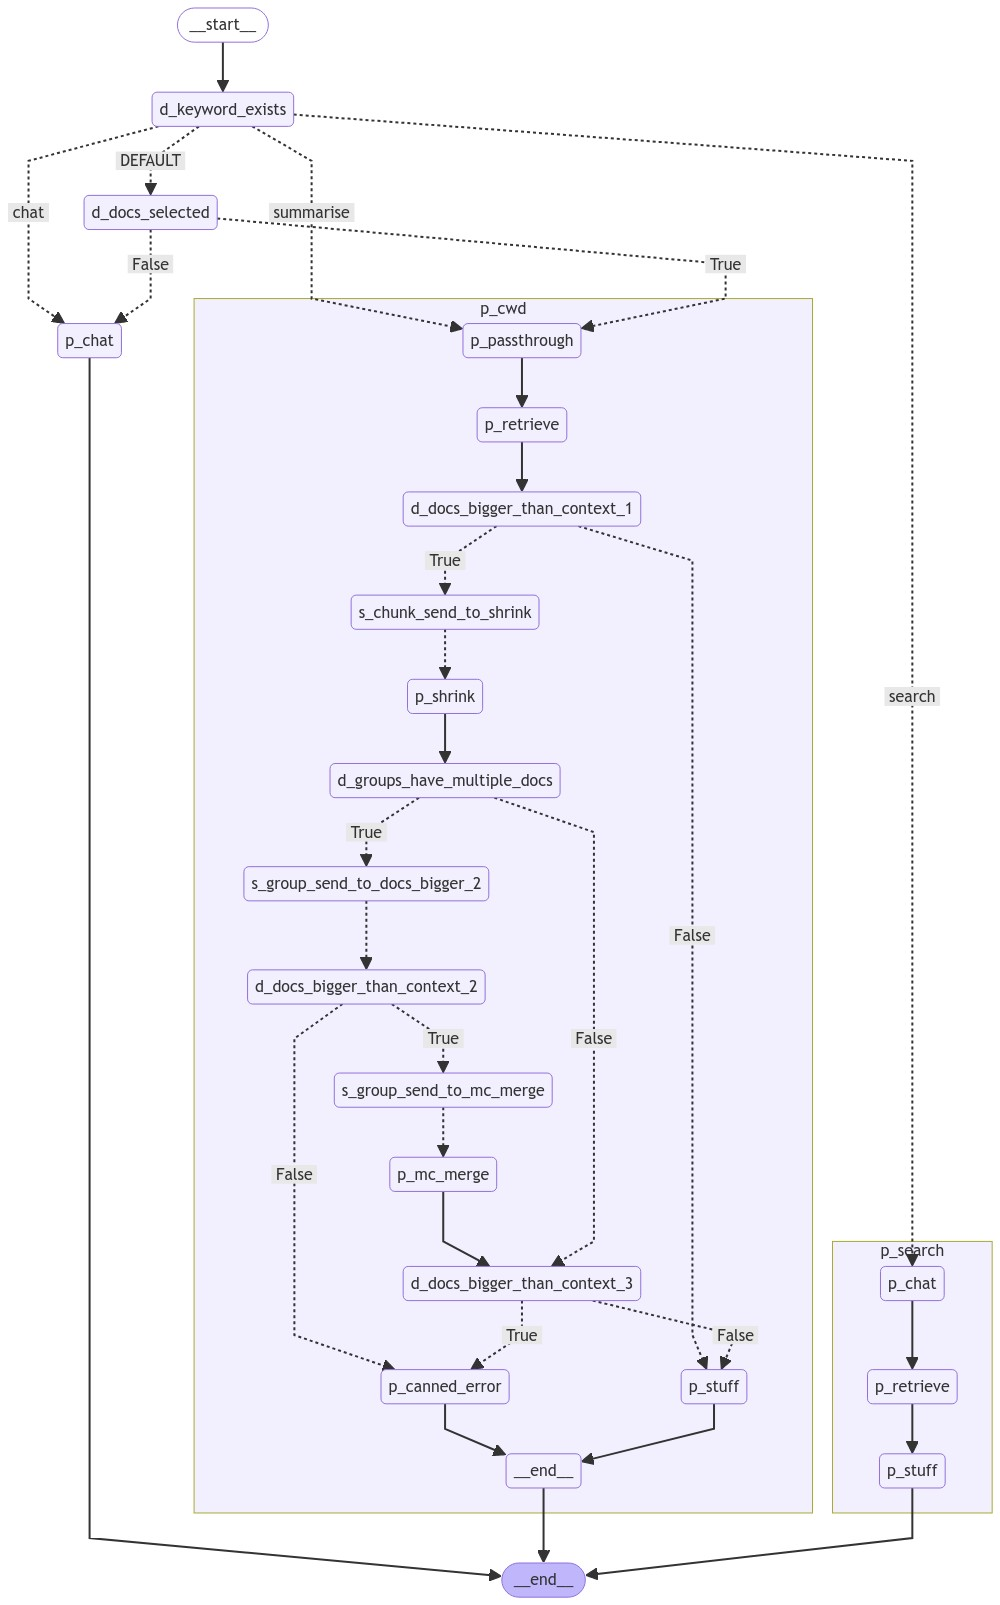

In [58]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app_compiled.get_graph(xray=True).draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)